# Chroma from Luma Prediction

In this notebook, we revisit the [zero-mean chroma and luma](https://github.com/luctrudeau/CfL-Analysis/blob/master/notebooks/exploratory/0.01a-luctrudeau-ZeroMeanChromaAndLuma.ipynb) experiment and add chroma from luma prediction based on the equations in the [least squares simplification](https://github.com/luctrudeau/CfL-Analysis/blob/master/notebooks/exploratory/0.02-luctrudeau-LeastSquaresSimplification.ipynb) notebook.

In [1]:
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import load_paths
from src.data import make_kodim

import matplotlib.pyplot as plt
import numpy as np

[kodims, kodim_files] = make_kodim.load_kodim()

## Parameters for the experience

In [2]:
# Block size used to compare luma and chroma 
block_size = 32

# Image used
im = kodims[4]

## Predicting U from dY

For each block in the image, we plot the zero-mean Y values along the zero-mean X axis, the U values along the Y axis and the linear chroma from luma prediction (in green).

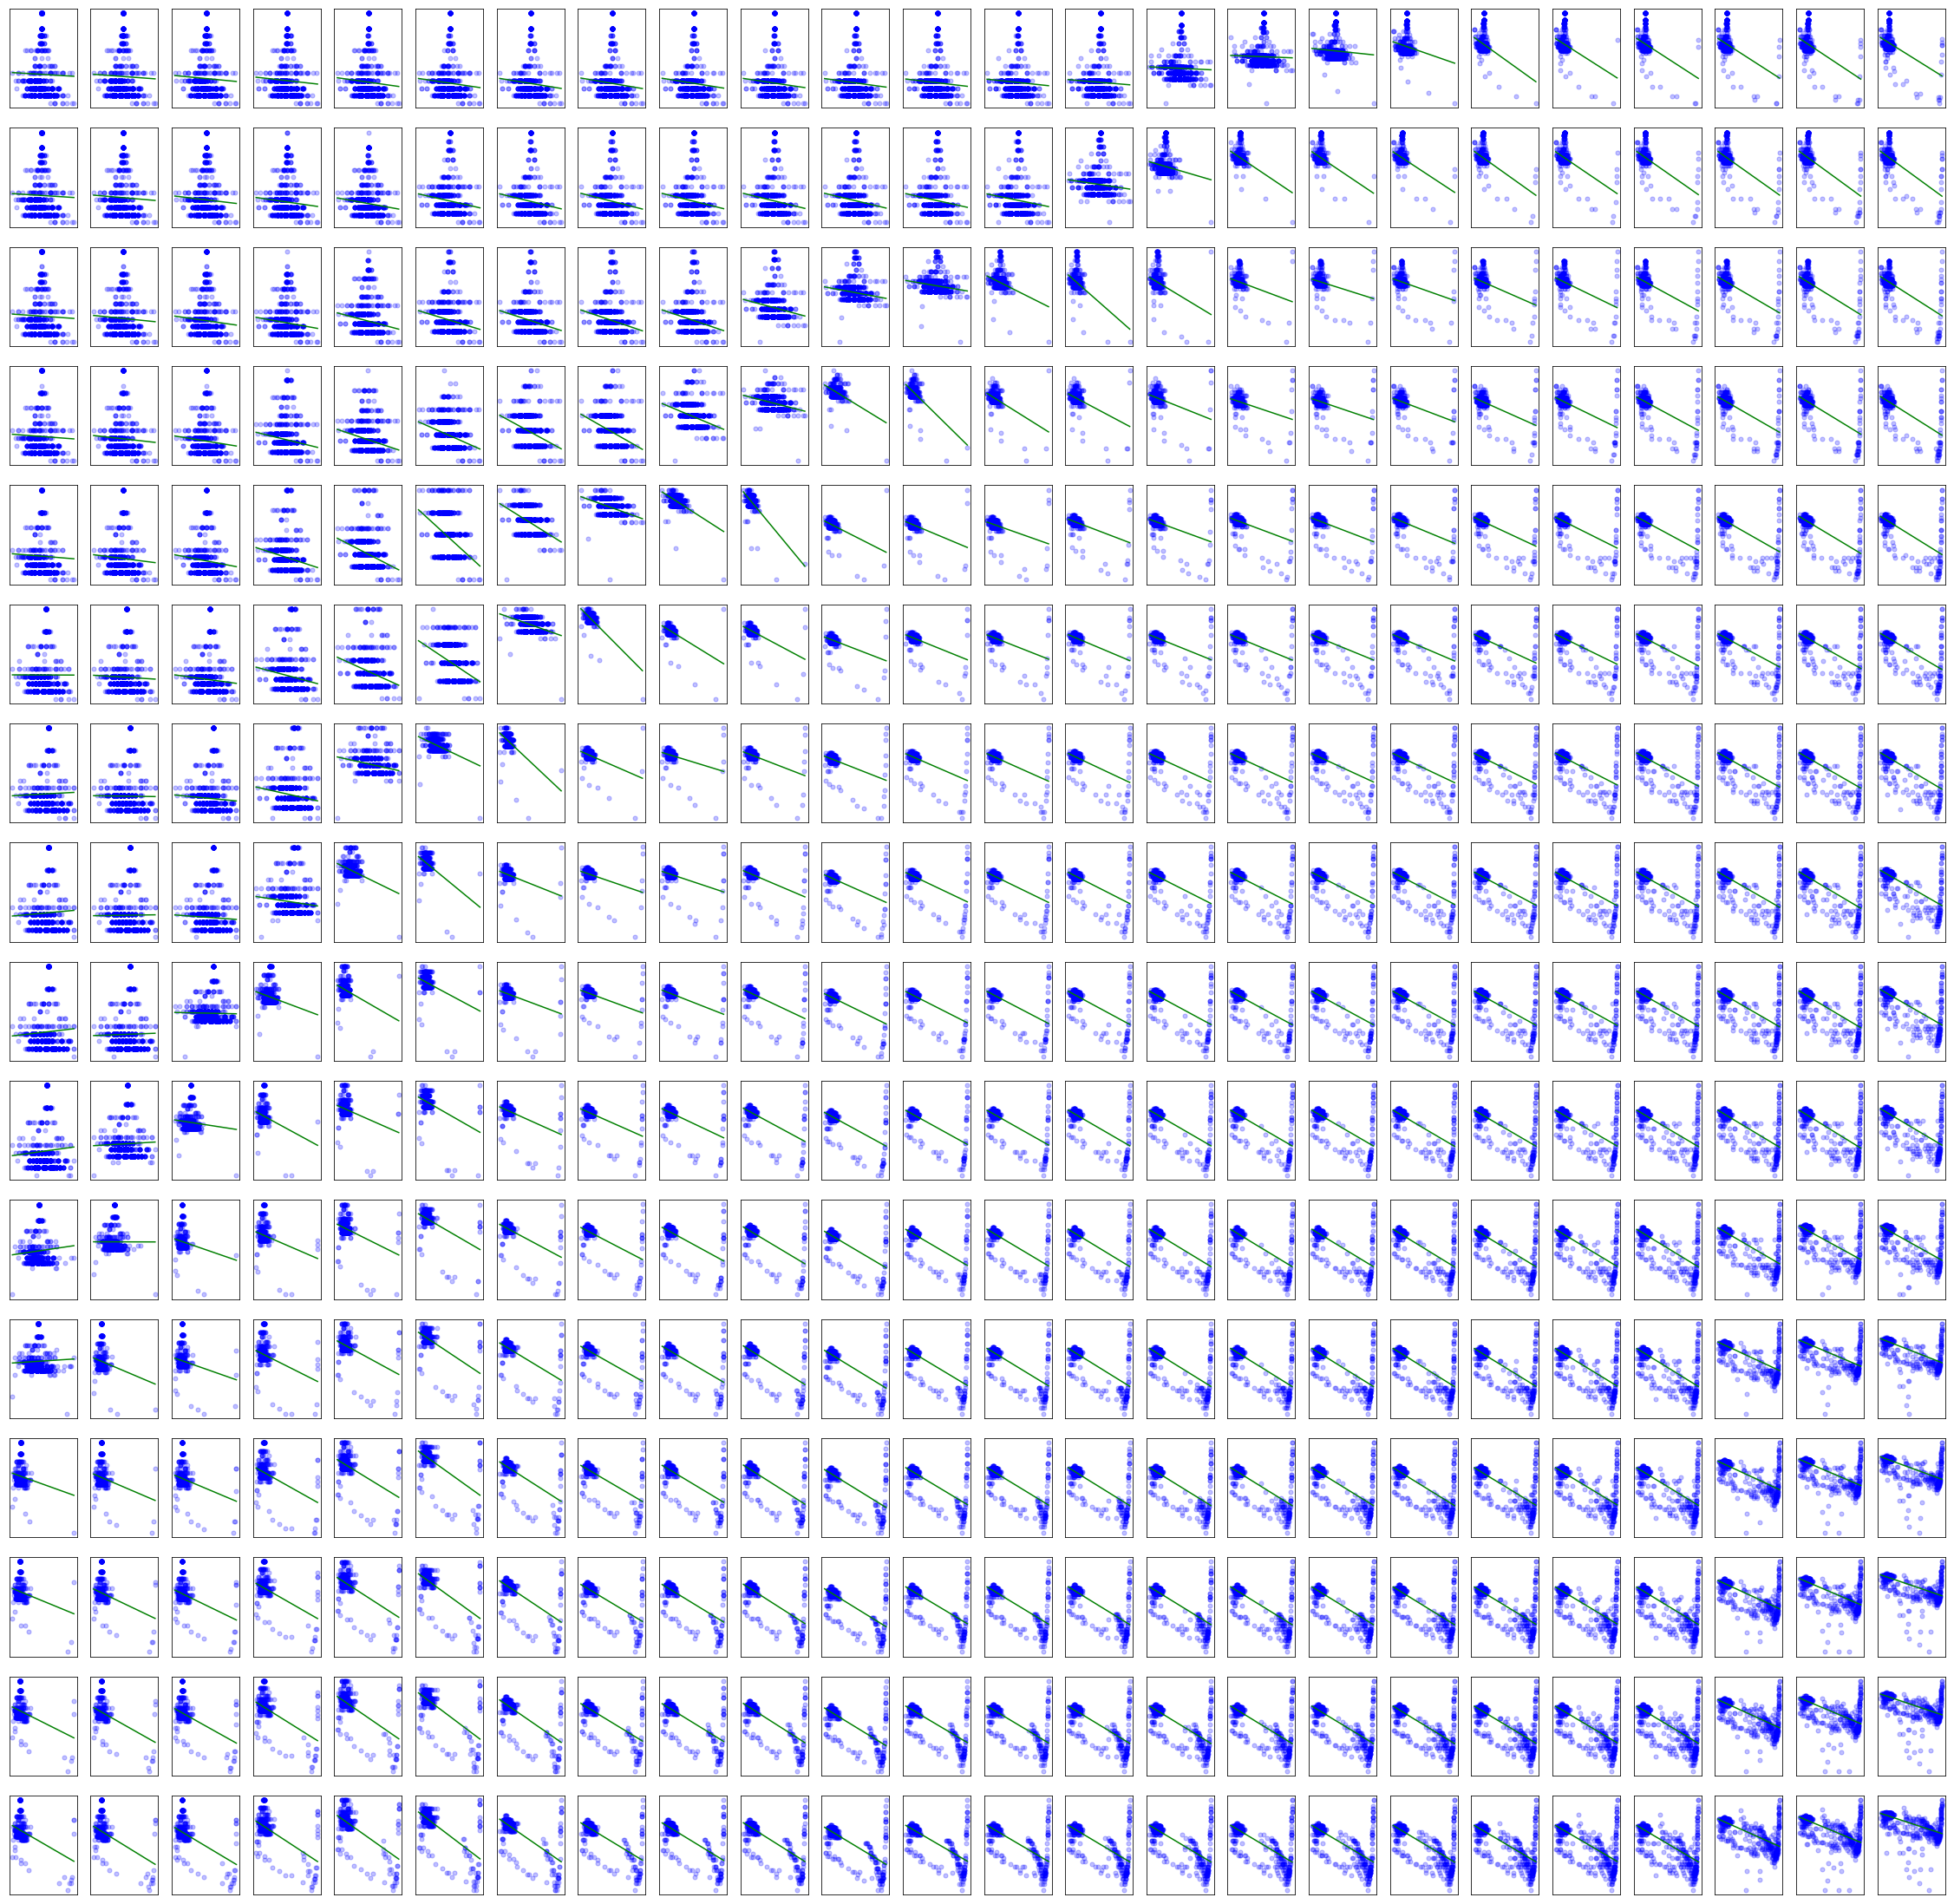

In [3]:
height, width, z = im.shape
plot_width = int(width / block_size)
plot_height = int(height / block_size)

alphaU = np.zeros((plot_height, plot_width))
errU = np.zeros((plot_height, plot_width))
avg_errU = np.zeros((plot_height, plot_width))

plt.figure(figsize=(40,40))
yy = 0
zz = 1
for y in range(0, height, block_size):
    xx = 0
    for x in range(0, width, block_size):
        bY = im[yy:yy+block_size,xx:xx+block_size,0].ravel()
        bU = im[yy:yy+block_size,xx:xx+block_size,1].ravel()
        
        avgY = np.mean(bY)
        avgU = np.mean(bU)
        
        dY = bY - avgY
        dU = bU - avgU
        
        sY2 = np.sum(dY**2)
        sYU = np.sum(dY*dU)
        
        a = sYU / sY2
        dY_sorted = np.sort(dY)
        cfl = a * dY_sorted + avgU
        alphaU[yy,xx] = a
        
        errU[yy, xx] = np.sum((bU - (a * dY + avgU))**2)
        avg_errU[yy, xx] = np.sum((bU - avgU)**2)
        
        plt.subplot(plot_height,plot_width, zz)
        plt.scatter(dY, bU, c="blue", alpha=0.25, s=25)
        plt.plot(dY_sorted , cfl, c="green")

        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])
        xx = xx + 1
        zz = zz + 1
    yy = yy + 1

## Predicting V from dY

For each block in the image, we plot the zero-mean Y values along the zero-mean X axis, the V values along the Y axis and the linear chroma from luma prediction (in green).

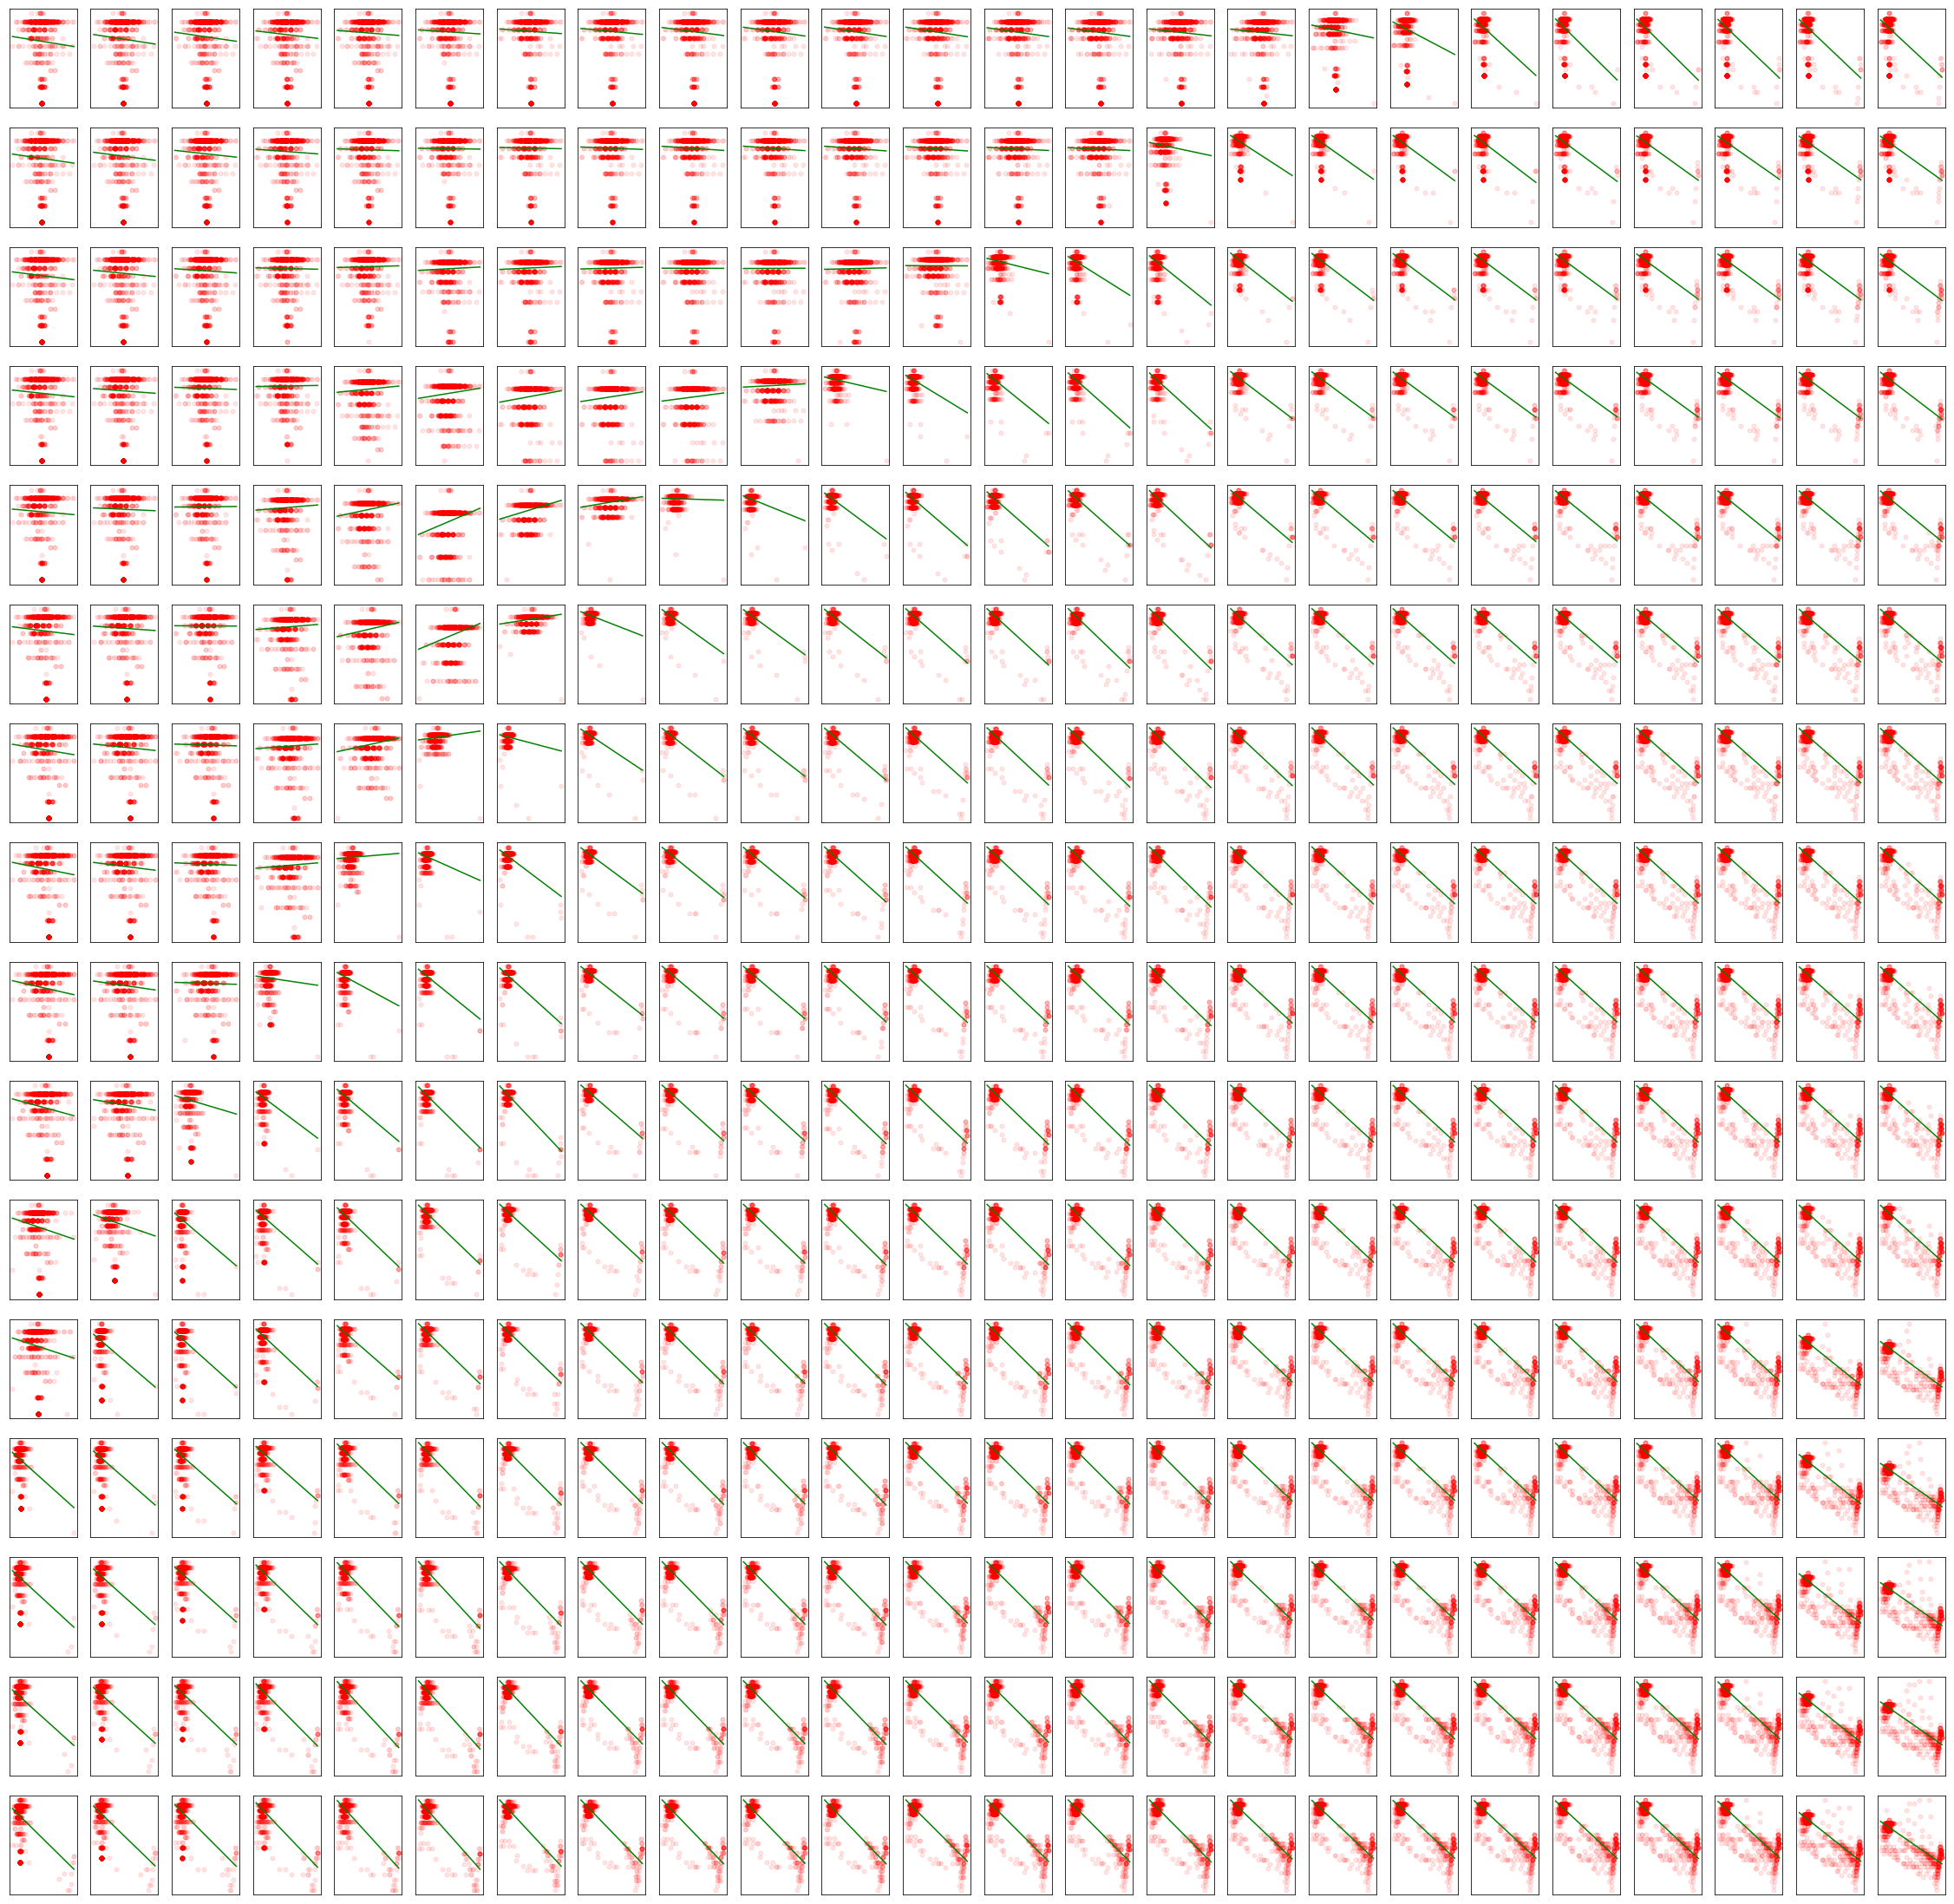

In [4]:
alphaV = np.zeros((plot_height, plot_width))
errV = np.zeros((plot_height, plot_width))
avg_errV = np.zeros((plot_height, plot_width))

plt.figure(figsize=(40,40))
yy = 0
zz = 1
for y in range(0, height, block_size):
    xx = 0
    for x in range(0, width, block_size):
        bY = im[yy:yy+block_size,xx:xx+block_size,0].ravel()
        bV = im[yy:yy+block_size,xx:xx+block_size,2].ravel()
        
        avgY = np.mean(bY)
        avgV = np.mean(bV)
        
        dY = bY - avgY
        dV = bV - avgV
        
        sY2 = np.sum(dY**2)
        sYV = np.sum(dY*dV)
        
        a = sYV / sY2
        dY_sorted = np.sort(dY)
        cfl = a * dY_sorted + avgV
        alphaV[yy,xx] = a
        
        errV[yy, xx] = np.sum((bV - (a * dY + avgV))**2)
        avg_errV[yy, xx] = np.sum((bV - avgV)**2)
        
        plt.subplot(plot_height,plot_width, zz)
        plt.scatter(dY, bV, c="red", alpha=0.10, s=25)
        plt.plot(dY_sorted, cfl, c="green")
        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])
        xx = xx + 1
        zz = zz + 1
    yy = yy + 1

## Correlation between $\alpha$ values

In the previous plots, $\alpha$ represents the slope of the green line, we can see a correlation between theses slopes. In the following bar chart, we measure the correlation of the alphas for each row of the image.

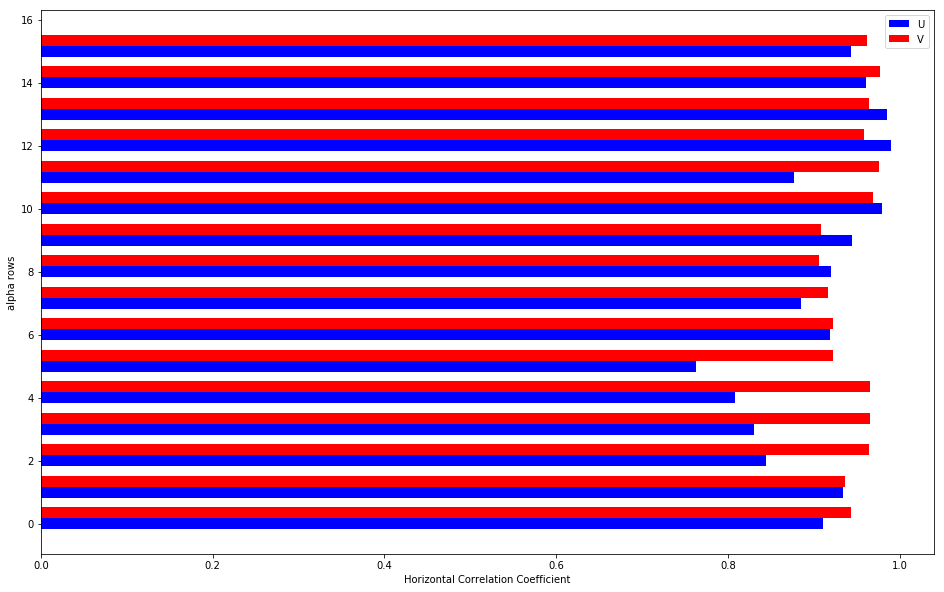

In [5]:
corr_aU = np.zeros((plot_height, 1))
corr_aV = np.zeros((plot_height, 1))

yy = 0
for y in range(0, height, block_size):
    aU = alphaU[yy,:]
    aV = alphaV[yy,:]
    
    corr_aU[yy] = np.corrcoef(aU[1:], aU[:-1])[0,1]
    corr_aV[yy] = np.corrcoef(aV[1:], aV[:-1])[0,1]
    yy = yy + 1

step = 0.35 
plt.figure(figsize=(16,10))
plt.barh(np.arange(plot_height), corr_aU.ravel(), step, color='b', label='U');
plt.barh(np.arange(plot_height) + step, corr_aV.ravel(), step, color='r', label='V');
plt.xlabel("Horizontal Correlation Coefficient")
plt.ylabel("alpha rows")
plt.legend(loc='best');

## Prediction Error

In the following plots, we compare CfL with a predictor that only uses the average of the block in the current plane. CfL prediction can be considered as a first order predictor and the average based prediction as a zero order predictor. As such, in the worst case, CfL will perform as bad as the average predictor ($\alpha = 0$).


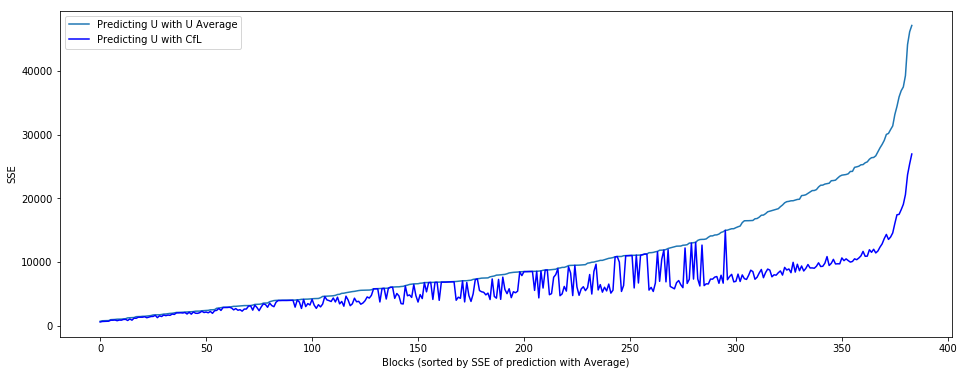

In [6]:
plt.figure(figsize=(16,6))
ind = np.argsort(avg_errU.ravel())
plt.plot(avg_errU.ravel()[ind], label='Predicting U with U Average');
plt.plot(errU.ravel()[ind], label='Predicting U with CfL', color='blue');
plt.xlabel("Blocks (sorted by SSE of prediction with Average)")
plt.ylabel("SSE")
plt.legend(loc='best');

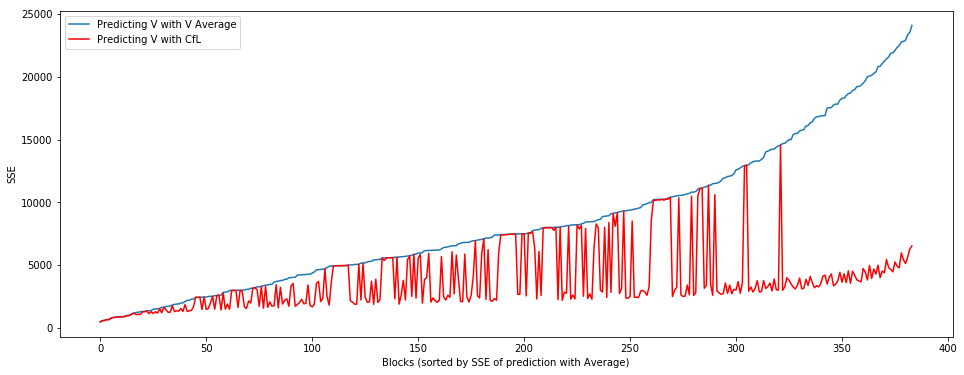

In [7]:
plt.figure(figsize=(16,6))
ind = np.argsort(avg_errV.ravel())
plt.plot(avg_errV.ravel()[ind], label='Predicting V with V Average');
plt.plot(errV.ravel()[ind], label='Predicting V with CfL', color='red');
plt.xlabel("Blocks (sorted by SSE of prediction with Average)")
plt.ylabel("SSE")
plt.legend(loc='best');